In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from fcapy.lattice import ConceptLattice
from fcapy.context import FormalContext
import os 

    
output_dir = 'output'
os.makedirs(output_dir, exist_ok=True)
 

In [103]:
# 1. Load Datasets and Compare Columns
df_2017 = pd.read_csv("data/Financia_literacy_2017.csv")
df_2020 = pd.read_csv("data/Financia_literacy_2020.csv")

geodemo = ["AREA5","qd10", "qd9"]

if (df_2020.columns == df_2017.columns).all():
    print("PASS_20_17")
else:
    print("FAIL_20_17")
    print("df_20: YES , df_17: NO", set(df_2020.columns) - set(df_2017.columns))
    print("df_17: YES , df_20: NO", set(df_2017.columns) - set(df_2020.columns))

db=df_2017

# 3. Preprocess qprod1_d, qprod2, qk4, qk5, and qf10_* Variables
db.fillna({"qprod1_d": 99, "qprod2": -99}, inplace=True)

db['qk4'] = np.where(db['qk4'].isin([-97, -99, 0]), db['qk4'], 1)
db['qk5'] = np.where(db['qk5'].isin([-97, -99, 102]), db['qk5'], 1)

qf10_cols = [col for col in db.columns if col.startswith("qf10_")]
for col in qf10_cols:
    mode_value = db[col].mode()[0]
    db[col] = db[col].replace([-97, -99], mode_value)

# 4. Define Variables Type and Encode Variables Categorical ones
binary_variables = [
    "qd1", "SM", "qd12", "qprod1c_1", "qprod1c_2", "qprod1c_3", "qprod1c_5", "qprod1c_6", "qprod1c_7",
    "qprod1c_8", "qprod1c_10", "qprod1c_11", "qprod1c_12", "qprod1c_14", "qprod1c_99", "qf3_1", "qf3_3", "qf3_4",
    "qf3_6", "qf3_7", "qf3_8", "qf3_99", "qf9_1", "qf9_10", "qf9_2", "qf9_3", "qf9_4", "qf9_5", "qf9_6", "qf9_7",
    "qf9_8", "qf9_9", "qf9_99", "qprod3_1", "qprod3_2", "qprod3_3", "qprod3_4", "qprod3_5", "qprod3_6", "qprod3_7",
    "qprod3_8", "qprod3_9", "qprod3_10", "qprod3_11", "qprod3_12", "qprod3_13", "qprod3_14", "qprod3_15", "qprod3_16",
    "qprod3_17", "qprod3_18", "qprod3_99", "qf12_1_a", "qf12_1_b", "qf12_1_c", "qf12_2_d", "qf12_3_e", "qf12_3_f",
    "qf12_3_g", "qf12_4_k", "qf12_4_l", "qf12_5_m", "qf12_5_o", "qf12_6_p", "qf12_6_q", "qf12_7_r", "qf12_97", "qf12_99"
]
integer_variables = ["qd5b", "qd7"] + qf10_cols
continuous_variables = ["pesofitc"]

categorical_variables = db.columns.difference(binary_variables + integer_variables + continuous_variables)

encoder = OneHotEncoder(drop='first')
encoded_cols = encoder.fit_transform(db[categorical_variables])
encoded_df = pd.DataFrame(encoded_cols.toarray(), columns=encoder.get_feature_names_out(categorical_variables))

# 5. Create and Finalize the Final DataFrame
db_final = pd.concat([db[binary_variables + integer_variables + geodemo], encoded_df], axis=1).fillna(0)

# 6. Check for Missing Values
if db_final.isna().any().any():
    print("Missing values exist.")
else:
    print("No missing values.")

PASS_20_17
No missing values.


In [107]:
# Definizione delle generazioni basate sull'anno di nascita
def categorize_generation(age):
    if age >= 80:  # Nati prima del 1945
        return "Silent_Generation"
    elif 64 <= age <= 79:  # Nati tra 1945 e 1960
        return "Boomers"
    elif 50 <= age <= 63:  # Nati tra 1961 e 1974
        return "Gen_X"
    elif 34 <= age <= 49:  # Nati tra 1975 e 1990
        return "Millennials"
    elif 18 <= age <= 33:  # Nati tra 1991 e 2006
        return "Gen_Z"
    else:
        return "Unknown"

# Definizione delle generazioni basate sull'anno di nascita
def categorize_education(edu):
    if edu == 1:  # Nati prima del 1945
        return "University"
    elif edu == 3:  # Nati tra 1945 e 1960
        return "Diploma"
    else:
        return "No_diploma"

# Creazione della nuova colonna con la generazione
db_final["education"] = db_final["qd9"].apply(categorize_education)

# Creazione della nuova colonna con la generazione
db_final["generation"] = db_final["qd7"].apply(categorize_generation)

# Seleziona le due variabili da usare per la segmentazione
var1 = "education"  # Sostituisci con il nome della prima variabile
var2 = "generation" 

# Creazione di una nuova variabile che è la concatenazione dei valori di var1 e var2
db_final["segmentation"] = db_final[var1].astype(str) + "_" + db_final[var2].astype(str) 

In [108]:
knowledge_answer = ["qk3_2","qk3_3","qk3_-97","qk3_1", #qk3
                       "qk4_1","qk4_-97","qk4_0", #qk4
                       "qk5_1","qk5_-97","qk5_102", #qk5
                       "qk6_2","qk6_3","qk6_4","qk6_-97","qk6_1", #qk6
                       "qk7_1_0","qk7_1_-97","qk7_1_1", #qk7_1
                       "qk7_2_0","qk7_2_-97","qk7_2_1", #qk7_2
                       "qk7_3_0","qk7_3_-97","qk7_3_1",] #qk7_3

behevioral_answer =  ["qf1_2","qf1_3","qf1_1", #qf1
                        "qf2_0","qf2_1", #qf2
                        "qf3_1","qf3_3","qf3_4","qf3_6","qf3_7","qf3_8","qf3_99", #qf3
                        "qf10_1", #qf10_1
                        "qf10_4", #qf10_4
                        "qf10_6", #qf10_6
                        "qf10_7", #qf10_7
                        "qprod2_2.0","qprod2_3.0","qprod2_4.0","qprod2_1.0", #qprod2
                        "qprod3_1","qprod3_2","qprod3_3","qprod3_4","qprod3_5","qprod3_6","qprod3_7","qprod3_8","qprod3_9","qprod3_10","qprod3_11","qprod3_12","qprod3_13","qprod3_14","qprod3_15","qprod3_16","qprod3_17","qprod3_18","qprod3_99", #qprod3
                        "qf12_1_a","qf12_1_b","qf12_1_c","qf12_2_d","qf12_3_e","qf12_3_f","qf12_3_g","qf12_4_k","qf12_4_l","qf12_5_m","qf12_5_o","qf12_6_p","qf12_6_q","qf12_7_r","qf12_97","qf12_99" #qf12
                        ]

attitude_answer = ["qf10_2","qf10_3","qf10_8"] #qf10

In [109]:
import pandas as pd

# Creazione dei punteggi di conoscenza (Knowledge Score)
db_final["qk3_score"] = (db_final["qk3_3"] == 1).astype(int)
db_final["qk4_score"] = (db_final["qk4_0"] == 1).astype(int)
db_final["qk5_score"] = (db_final["qk5_102"] == 1).astype(int)
db_final["qk6_score"] = (db_final["qk6_1"] == 1).astype(int)
db_final["qk7_1_score"] = (db_final["qk7_1_1"] == 1).astype(int)
db_final["qk7_2_score"] = (db_final["qk7_2_1"] == 1).astype(int)
db_final["qk7_3_score"] = (db_final["qk7_3_1"] == 1).astype(int)

# Creazione dei punteggi comportamentali (Behavioral Score)
db_final["qf1_qf2_score"] = (((db_final["qf1_1"] == 1) | (db_final["qf1_2"] == 1)) & (db_final["qf2_1"] == 1)).astype(int)
db_final["qf3_score"] = db_final[["qf3_1", "qf3_4", "qf3_6", "qf3_7", "qf3_8"]].sum(axis=1).gt(0).astype(int)
db_final["qf10_1_score"] = db_final["qf10_1"].isin([1, 2]).astype(int)
db_final["qf10_4_score"] = db_final["qf10_4"].isin([1, 2]).astype(int)
db_final["qf10_6_score"] = db_final["qf10_6"].isin([1, 2]).astype(int)
db_final["qf10_7_score"] = db_final["qf10_7"].isin([1, 2]).astype(int)

# Creazione delle variabili temporanee per la produzione
db_final["temp_qprod2"] = db_final[["qprod2_1.0", "qprod2_4.0"]].sum(axis=1).gt(0).astype(int)

db_final["temp_qprod3"] = (
    (db_final[["qprod3_5", "qprod3_6", "qprod3_7", "qprod3_8"]].sum(axis=1) > 0).astype(int) * 2 +
    (db_final[["qprod3_2", "qprod3_3", "qprod3_4", "qprod3_9", "qprod3_10", "qprod3_11", "qprod3_12", "qprod3_13", "qprod3_18"]].sum(axis=1) > 0).astype(int)
)

db_final["qprod_2pt_score"] = (db_final["temp_qprod3"] == 2).astype(int)
db_final["qprod_1pt_score"] = ((db_final["temp_qprod2"] == 1) | (db_final["temp_qprod3"] == 1)).astype(int)

credit_columns = ["qf12_3_e", "qf12_3_f", "qf12_3_g", "qf12_4_k", "qf12_4_l", "qf12_5_m",
                  "qf12_5_o", "qf12_6_p", "qf12_6_q"]

db_final["qf12_score"] = (db_final[credit_columns].sum(axis=1) == 0).astype(int)

# Creazione del punteggio di atteggiamento (Attitude Score)
db_final["qf10_2_score"] = db_final["qf10_2"].isin([4, 5]).astype(int)
db_final["qf10_3_score"] = db_final["qf10_3"].isin([4, 5]).astype(int)
db_final["qf10_8_score"] = db_final["qf10_8"].isin([4, 5]).astype(int)


In [111]:
knowledge_score_variables = [
    "qk3_score", "qk4_score", "qk5_score", "qk6_score", 
    "qk7_1_score", "qk7_2_score", "qk7_3_score"
]

# Behavioral Score
behavioral_score_variables = [
    "qf1_qf2_score", "qf3_score", "qf10_1_score", 
    "qf10_4_score", "qf10_6_score", "qf10_7_score",
    "qprod_2pt_score", "qprod_1pt_score", "qf12_score"
]

# Attitude Score
attitude_score_variables = [
    "qf10_2_score", "qf10_3_score", "qf10_8_score"
]

variabili_fca = knowledge_score_variables + behavioral_score_variables + attitude_score_variables

geodemo = ["qd1", "AREA5", "qd5b", "generation", "qd10", "education", "qd12", "segmentation"]

In [112]:
db_analysis = db_final[geodemo + knowledge_score_variables + behavioral_score_variables + attitude_score_variables]

In [113]:
db_analysis["total_score"] = db_final[variabili_fca].sum(axis=1)

C:\Users\giuly\AppData\Local\Temp\ipykernel_4344\1713651054.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  db_analysis["total_score"] = db_final[variabili_fca].sum(axis=1)


In [116]:
import pandas as pd
from sklearn.model_selection import train_test_split

def create_train_test_set(data: pd.DataFrame, test_size: float = 0.3, random_state: int = 42):
    """
    Funzione per creare i set di train e test da un DataFrame.
    
    :param data: DataFrame contenente i dati del database
    :param test_size: Percentuale di dati da riservare per il test (default 0.2 = 20%)
    :param random_state: Semenza per la randomizzazione della divisione dei dati (default 42)
    
    :return: due DataFrame (train_set, test_set)
    """
    
    # Creare il train e test set utilizzando train_test_split
    train_set, test_set = train_test_split(data, test_size=test_size, random_state=random_state)
    
    return train_set, test_set

# Esempio di utilizzo:
# Carica i dati (nel tuo caso, può essere un database caricato in un DataFrame pandas)
# Ad esempio:
# data = pd.read_csv('path_to_your_data.csv')

# Creare il train e test set (80% training, 20% testing)
train_data, test_data = create_train_test_set(db_analysis)

# Visualizza una parte dei set creati per verificarne il contenuto
print("Train set:", train_data.head())
print("Test set:", test_data.head())


Train set:       qd1  AREA5  qd5b         generation  qd10   education  qd12  \
836     1      1     2            Boomers     6  University     0   
1891    0      3     2  Silent_Generation     6  No_diploma     1   
903     1      2     3              Gen_Z     2  University     1   
2336    1      5     5              Gen_X     1  No_diploma     1   
483     1      5     3            Boomers     6  No_diploma     0   

                      segmentation  qk3_score  qk4_score  ...  qf10_4_score  \
836             University_Boomers          0          0  ...             1   
1891  No_diploma_Silent_Generation          1          0  ...             0   
903               University_Gen_Z          1          1  ...             0   
2336              No_diploma_Gen_X          0          0  ...             1   
483             No_diploma_Boomers          1          0  ...             0   

      qf10_6_score  qf10_7_score  qprod_2pt_score  qprod_1pt_score  \
836              1           

In [214]:
class AssociationRules:
    def __init__(self, data: pd.DataFrame, columns_A: list, columns_B: list, group: str):
        """
        data: DataFrame principale
        columns_A: colonne per l'insieme A
        columns_B: colonne per l'insieme B
        group: stringa per la colonna 'group' nell'output finale
        """
        self.data = data
        self.columns_A = columns_A
        self.columns_B = columns_B
        self.group = group  # Nuovo parametro 'group'

    def support(self, itemset):
        """
        Calcola il supporto di un insieme di item.
        """
        return (self.data[itemset].all(axis=1).sum()) / len(self.data)

    def confidence(self, itemset_A, itemset_B):
        """
        Calcola la confidenza della regola A -> B.
        """
        support_A_and_B = (self.data[itemset_A + itemset_B].all(axis=1).sum()) / len(self.data)
        support_A = self.support(itemset_A)
        return support_A_and_B / support_A if support_A != 0 else 0

    def lift(self, itemset_A, itemset_B):
        """
        Calcola il lift della regola A -> B.
        """
        support_A_and_B = (self.data[itemset_A + itemset_B].all(axis=1).sum()) / len(self.data)
        support_A = self.support(itemset_A)
        support_B = self.support(itemset_B)

        if support_A != 0 and support_B != 0:
            return support_A_and_B / (support_A * support_B)
        else:
            return 0

    def get_combinations(self, itemset):
        """
        Genera tutte le combinazioni di sottoinsiemi per un dato insieme, senza alcuna dimensione massima.
        """
        all_combinations = []

        # Genera tutte le combinazioni di sottoinsiemi senza limitazione di dimensione
        for size in range(1, len(itemset) + 1):
            for combination in itertools.combinations(itemset, size):
                all_combinations.append(combination)

        return all_combinations

    def filter_duplicate_combinations(self, combinations, itemset):
        """
        Filtra le combinazioni che non si verificano nel dataset.
        """
        valid_combinations = []
        for combination in combinations:
            # Verifica che la combinazione effettivamente esista nel dataset
            if self.data[list(combination)].all(axis=1).any():
                valid_combinations.append(combination)
        return valid_combinations

    def calculate_metrics_for_pair(self, itemset_A, itemset_B):
        """
        Calcola Supporto, Confidenza e Lift per una coppia di insiemi A e B.
        """
        support_A_and_B = self.support(list(itemset_A) + list(itemset_B))
        confidence = self.confidence(list(itemset_A), list(itemset_B))
        lift = self.lift(list(itemset_A), list(itemset_B))

        result = {
            'A': itemset_A,
            'B': itemset_B,
            'Support': support_A_and_B,
            'Confidence': confidence,
            'Lift': lift,
            'Group': self.group  # Aggiungi il group a ciascun risultato
        }

        return result

    def calculate_all_metrics_for_selected_sets(self):
        """
        Calcola Supporto, Confidenza e Lift per le combinazioni selezionate di A e B.
        """
        # Seleziona le colonne valide per A e B
        valid_columns_A = self.data.columns.intersection(self.columns_A).tolist()
        valid_columns_B = self.data.columns.intersection(self.columns_B).tolist()

        # Verifica che le colonne non siano vuote
        if len(valid_columns_A) == 0 or len(valid_columns_B) == 0:
            print("Nessuna combinazione possibile: colonne vuote.")
            return pd.DataFrame()  # Nessuna combinazione possibile

        # Genera combinazioni per A e B senza limite sulla dimensione
        combinations_A = self.get_combinations(valid_columns_A)
        combinations_B = self.get_combinations(valid_columns_B)

        # Filtra le combinazioni duplicate (quelle che non si verificano nel dataset)
        combinations_A = self.filter_duplicate_combinations(combinations_A, valid_columns_A)
        combinations_B = self.filter_duplicate_combinations(combinations_B, valid_columns_B)

        # Calcola le metriche in parallelo
        results = Parallel(n_jobs=-1)(  # Parallelo per calcolare le metriche in parallelo
            delayed(self.calculate_metrics_for_pair)(itemset_A, itemset_B)
            for itemset_A in combinations_A
            for itemset_B in combinations_B
            if set(itemset_A).isdisjoint(itemset_B)  # A e B devono essere disgiunti
        )

        return pd.DataFrame(results)

    def filter_by_values(self, df, min_support=0, min_confidence=0, min_lift=0):
        """
        Filtra le regole di associazione in base ai valori fissi per Support, Confidence e Lift.
        Ogni metrica ha un valore minimo separato.
        """
        # Filtra i risultati in base ai valori minimi
        filtered_df = df[
            (df['Support'] >= min_support) & 
            (df['Confidence'] >= min_confidence) & 
            (df['Lift'] >= min_lift)
        ]

        return filtered_df


In [215]:
provaprova=train_data[train_data['segmentation']=="Diploma_Millennials"]

In [216]:
df = train_data

# Esempio di scelta di colonne per A e B
columns_A = knowledge_score_variables  # Queste sono le colonne per A
columns_B = behavioral_score_variables  # Queste sono le colonne per B

# Crea l'oggetto AssociationRules
ar = AssociationRules(provaprova, columns_A=columns_A, columns_B=columns_B, group="Diploma_Millennials")

# Calcola le regole di associazione per gli insiemi A e B selezionati
results = ar.calculate_all_metrics_for_selected_sets()

# Filtra le regole in base ai percentili
filtered_results_db = ar.filter_by_values(results, min_support=0, min_confidence=0, min_lift=0)


In [217]:
filtered_results_db

,A,B,Support,Confidence,Lift,Group
0,"(qk3_score,)","(qf1_qf2_score,)",0.124481,0.238095,0.796958,Diploma_Millennials
1,"(qk3_score,)","(qf3_score,)",0.344398,0.658730,1.024219,Diploma_Millennials
2,"(qk3_score,)","(qf10_1_score,)",0.431535,0.825397,0.999601,Diploma_Millennials
3,"(qk3_score,)","(qf10_4_score,)",0.402490,0.769841,1.025037,Diploma_Millennials
4,"(qk3_score,)","(qf10_6_score,)",0.340249,0.650794,0.986423,Diploma_Millennials
...,...,...,...,...,...,...
56764,"(qk3_score, qk4_score, qk5_score, qk6_score, q...","(qf3_score, qf10_4_score, qf10_6_score, qf10_7...",0.000000,0.000000,0.000000,Diploma_Millennials
56765,"(qk3_score, qk4_score, qk5_score, qk6_score, q...","(qf10_1_score, qf10_4_score, qf10_6_score, qf1...",0.004149,0.037037,4.462963,Diploma_Millennials
56766,"(qk3_score, qk4_score, qk5_score, qk6_score, q...","(qf1_qf2_score, qf3_score, qf10_1_score, qf10_...",0.004149,0.037037,2.975309,Diploma_Millennials
56767,"(qk3_score, qk4_score, qk5_score, qk6_score, q...","(qf1_qf2_score, qf10_1_score, qf10_4_score, qf...",0.004149,0.037037,8.925926,Diploma_Millennials


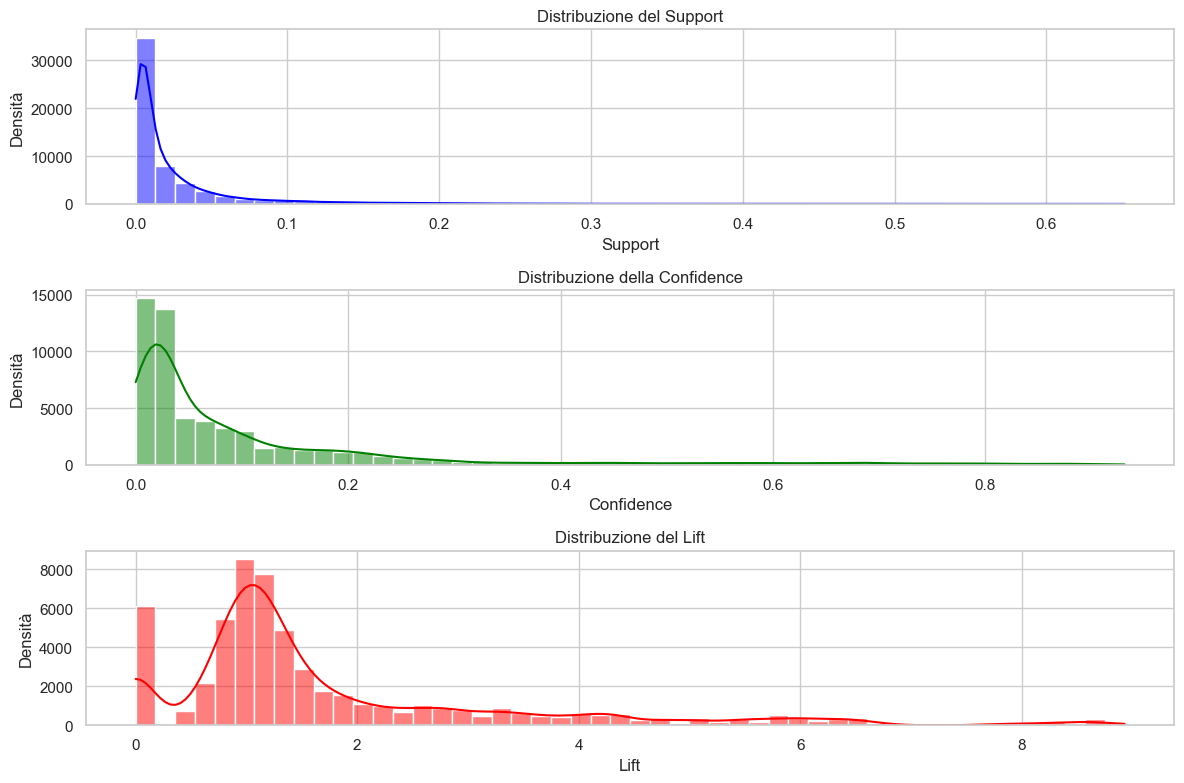

In [170]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_metrics_distribution(df):
    """
    Funzione per creare il grafico della distribuzione delle metriche di Lift, Confidence e Support.
    df: DataFrame contenente le colonne 'Support', 'Confidence' e 'Lift'.
    """
    # Impostare il tema di seaborn
    sns.set(style="whitegrid")
    
    # Creazione della figura
    plt.figure(figsize=(12, 8))
    
    # Distribuzione del Support
    plt.subplot(3, 1, 1)  # 3 righe, 1 colonna, 1° grafico
    sns.histplot(df['Support'], kde=True, color='blue', bins=50)
    plt.title('Distribuzione del Support')
    plt.xlabel('Support')
    plt.ylabel('Densità')

    # Distribuzione della Confidence
    plt.subplot(3, 1, 2)  # 3 righe, 1 colonna, 2° grafico
    sns.histplot(df['Confidence'], kde=True, color='green', bins=50)
    plt.title('Distribuzione della Confidence')
    plt.xlabel('Confidence')
    plt.ylabel('Densità')

    # Distribuzione del Lift
    plt.subplot(3, 1, 3)  # 3 righe, 1 colonna, 3° grafico
    sns.histplot(df['Lift'], kde=True, color='red', bins=50)
    plt.title('Distribuzione del Lift')
    plt.xlabel('Lift')
    plt.ylabel('Densità')

    # Mostra il grafico
    plt.tight_layout()  # Per evitare sovrapposizioni dei grafici
    plt.show()

# Esempio di utilizzo con il DataFrame 'df'
plot_metrics_distribution(filtered_results_db)


In [198]:
prova=filtered_results_db[(filtered_results_db["Support"]>0.1) & (filtered_results_db["Confidence"]>0.7) & (filtered_results_db["Lift"]>1.5)]
prova['Group'].value_counts()

Group
Diploma_Millennials    7
Name: count, dtype: int64

In [208]:
prova["B"]

30507    (qf10_4_score, qf10_6_score, qf12_score)
43917    (qf10_4_score, qf10_6_score, qf12_score)
44364    (qf10_4_score, qf10_6_score, qf12_score)
46599    (qf10_4_score, qf10_6_score, qf12_score)
51516    (qf10_4_score, qf10_6_score, qf12_score)
52857    (qf10_4_score, qf10_6_score, qf12_score)
53304    (qf10_4_score, qf10_6_score, qf12_score)
Name: B, dtype: object

In [203]:
df = test_data

# Esempio di scelta di colonne per A e B
columns_A = knowledge_score_variables  # Queste sono le colonne per A
columns_B = behavioral_score_variables  # Queste sono le colonne per B

# Crea l'oggetto AssociationRules
ar = AssociationRules(df, columns_A=columns_A, columns_B=columns_B, group="Diploma_Millennials")



In [206]:
df

,qd1,AREA5,qd5b,generation,qd10,education,qd12,segmentation,qk3_score,qk4_score,...,qf10_4_score,qf10_6_score,qf10_7_score,qprod_2pt_score,qprod_1pt_score,qf12_score,qf10_2_score,qf10_3_score,qf10_8_score,total_score
2055,0,3,1,Gen_X,2,No_diploma,0,No_diploma_Gen_X,0,0,...,1,1,0,0,0,1,1,0,0,7
1813,0,2,3,Gen_X,2,Diploma,1,Diploma_Gen_X,0,0,...,1,0,0,0,0,1,0,0,0,6
100,1,3,2,Gen_X,2,No_diploma,1,No_diploma_Gen_X,1,0,...,1,1,0,0,0,0,0,1,0,7
1349,1,1,5,Millennials,2,University,1,University_Millennials,1,1,...,0,0,0,0,0,0,1,0,0,9
56,0,1,3,Gen_Z,5,Diploma,1,Diploma_Gen_Z,0,1,...,1,1,1,0,0,1,0,0,0,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1486,0,1,1,Silent_Generation,6,No_diploma,1,No_diploma_Silent_Generation,0,0,...,1,1,1,0,1,1,1,0,0,8
2355,0,5,3,Millennials,4,Diploma,1,Diploma_Millennials,0,0,...,1,1,0,0,0,1,0,0,0,9
1420,0,2,2,Silent_Generation,6,No_diploma,1,No_diploma_Silent_Generation,0,0,...,1,1,0,0,0,1,1,0,0,7
998,0,3,4,Millennials,2,Diploma,1,Diploma_Millennials,1,0,...,1,0,0,0,0,1,0,0,0,5


In [209]:
a=["qk3_score", "qk4_score", "qk6_score", "qk7_2_score"]
b=["qf10_4_score", "qf10_6_score", "qf12_score"]

In [213]:
print(ar.support(a+b))
print(ar.confidence(a,b))
print(ar.lift(a,b))

0.08695652173913043
0.6138613861386139
1.1734133198842671
